In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST


In [3]:
dataset = MNIST(root='~/datasets', download=True);

Label: 5


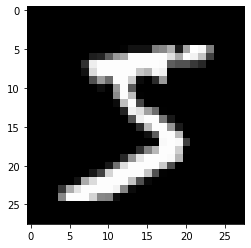

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)


In [6]:
import torchvision.transforms as transforms
dataset = MNIST(root='~/datasets', 
                train=True,
                transform=transforms.ToTensor())


In [7]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)


torch.Size([1, 28, 28]) 5


In [9]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)


(50000, 10000)

In [10]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)


In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 28*28
num_classes = 10

# Logistic regression model
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)  #reshape cuase this is nn not CNN, .linear will take only vectors.
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()
    


In [29]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.323922872543335, 'val_acc': 0.06279667466878891}

In [31]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [25]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9658, val_acc: 0.6068
Epoch [1], val_loss: 1.6894, val_acc: 0.7287
Epoch [2], val_loss: 1.4841, val_acc: 0.7655
Epoch [3], val_loss: 1.3297, val_acc: 0.7841
Epoch [4], val_loss: 1.2114, val_acc: 0.7965


In [34]:
history1

[{'val_loss': 1.9657686948776245, 'val_acc': 0.6068037748336792},
 {'val_loss': 1.689426302909851, 'val_acc': 0.7287381291389465},
 {'val_loss': 1.4841229915618896, 'val_acc': 0.7655261158943176},
 {'val_loss': 1.3296719789505005, 'val_acc': 0.7841178774833679},
 {'val_loss': 1.2114189863204956, 'val_acc': 0.7964794039726257}]

# Saving and loading the model


In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
